#Przegląd

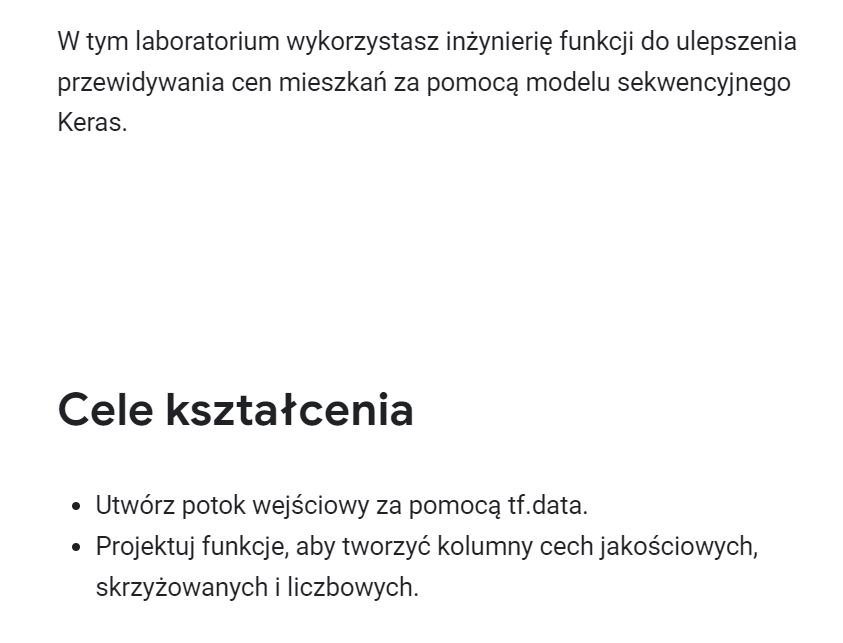

#Zadanie 1. Skonfiguruj swoje środowisko

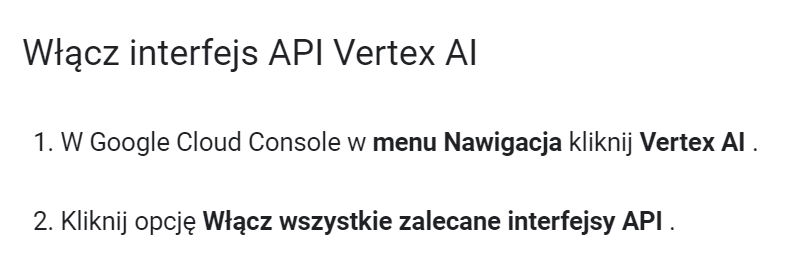

#Zadanie 2. Uruchom instancję Vertex AI Notebooks

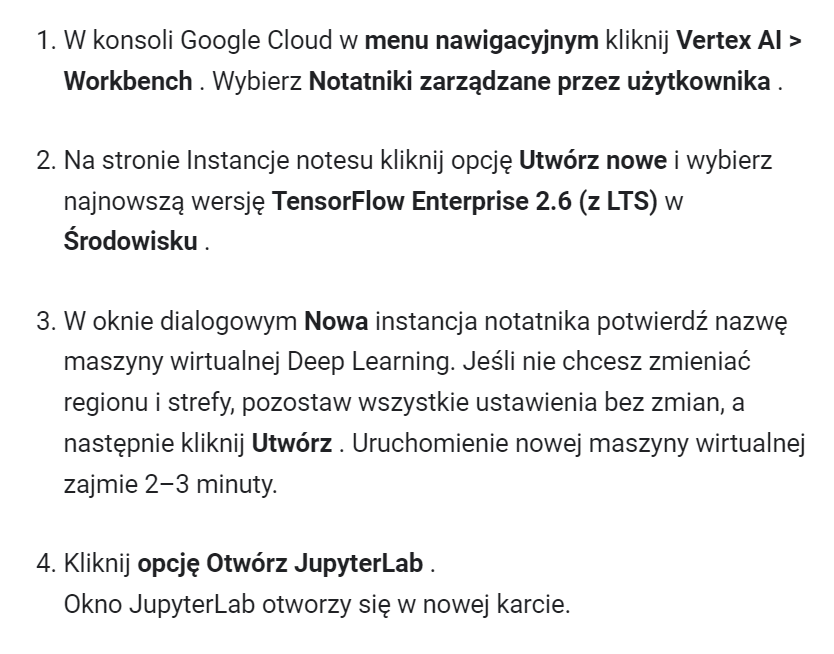

#Zadanie 3. Sklonuj repozytorium kursów w instancji Vertex AI Notebooks

In [ ]:
git clone https://github.com/GoogleCloudPlatform/training-data-analyst

#Zadanie 4. Wykonanie podstawowej inżynierii cech w Keras

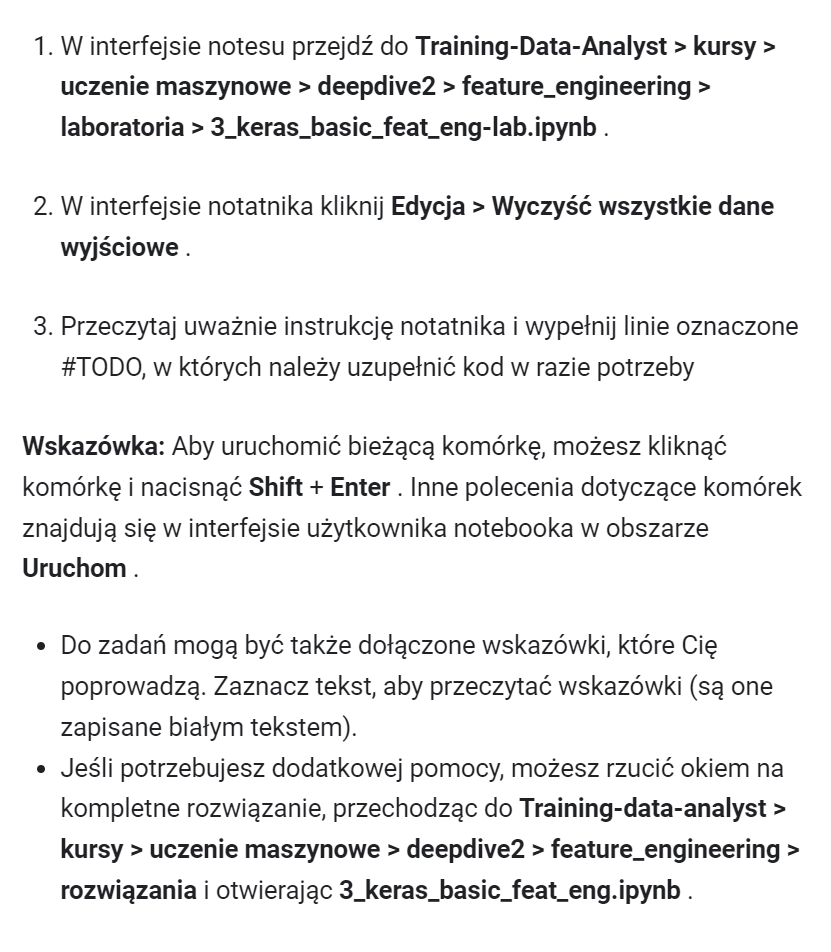

# Performing Basic Feature Engineering in Keras

## Learning objectives


1. Create an input pipeline using tf.data.
2. Engineer features to create categorical, crossed, and numerical feature columns.


## Introduction
In this lab, we utilize feature engineering to improve the prediction of housing prices using a Keras Sequential Model.  

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](../labs/3_keras_basic_feat_eng-lab.ipynb) -- try to complete that notebook first before reviewing this solution notebook.

# Wykonywanie podstawowej inżynierii cech w Keras

## Cele kształcenia


1. Utwórz potok wejściowy za pomocą pliku `tf.data`.
2. Projektuj funkcje, aby tworzyć kolumny cech kategorycznych, skrzyżowanych i liczbowych.


## Wstęp
W tym laboratorium wykorzystujemy inżynierię funkcji, aby ulepszyć przewidywanie cen mieszkań za pomocą modelu sekwencyjnego Keras.

Każdy cel edukacyjny będzie odpowiadał __#TODO__ w [notatniku laboratorium studenckiego](../labs/3_keras_basic_feat_eng-lab.ipynb) — spróbuj najpierw ukończyć ten notatnik, zanim przejrzysz notatnik z rozwiązaniem.

Zacznij od zaimportowania bibliotek niezbędnych do tego laboratorium.

In [ ]:
# Uruchom polecenie chown, aby zmienić właściciela
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [ ]:
# Install Sklearn
# scikit-learn simple and efficient tools for predictive data analysis
# Built on NumPy, SciPy, and matplotlib
!python3 -m pip install --user sklearn

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=3eb25fc76a7a56b67820f445014850e58a9deb2d22d54ab34215dca48a304bfe
  Stored in directory: /home/jupyter/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


### Zrestartuj jądro

Po zainstalowaniu pakietów należy ponownie uruchomić jądro notebooka, aby mógł je znaleźć. (Click Kernel > Restart Kernel > Restart).

In [ ]:
# You can use any Python source file as a module by executing an import statement in some other Python source file
# The import statement combines two operations; it searches for the named module, then it binds the
# results of that search to a name in the local scope.
import os
import tensorflow.keras

# Use matplotlib for visualizing the model
import matplotlib.pyplot as plt
# Import Pandas data processing libraries
import pandas as pd
import tensorflow as tf

from tensorflow import feature_column as fc
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
#from keras.utils import plot_model

print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  2.6.5



Wiele ćwiczeń z programowania w ramach kursów Google Machine Learning wykorzystuje [zestaw danych dotyczących mieszkań w Kalifornii](https://developers.google.com/machine-learning/crash-course/california-housing-data-description
), który zawiera dane pochodzące ze spisu ludności Stanów Zjednoczonych z 1990 r. Nasz zestaw danych laboratoryjnych został wstępnie przetworzony tak, aby nie brakowało żadnych wartości.

Najpierw pobierzmy surowe dane w formacie .csv, kopiując je z zasobnika w chmurze.


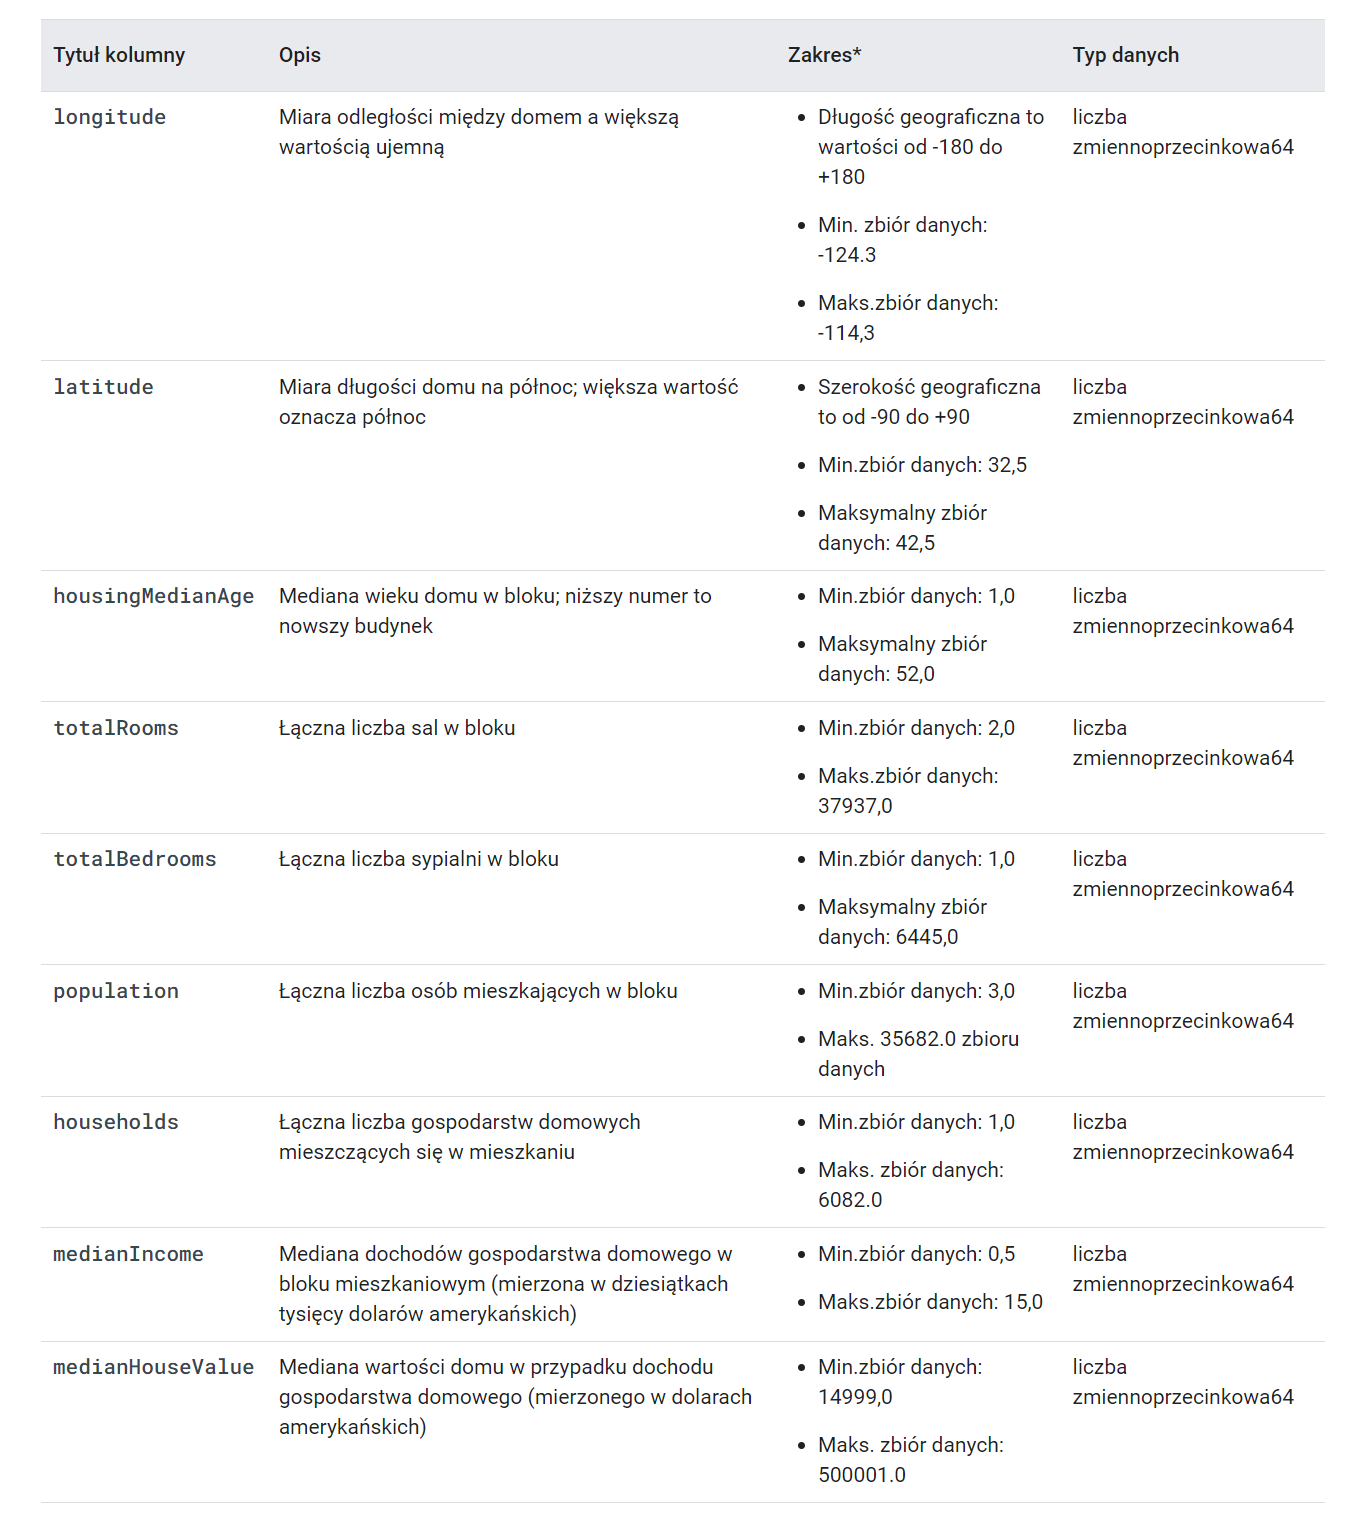

In [ ]:
if not os.path.isdir("../data"):
    os.makedirs("../data")

In [ ]:
# Pobierz surowe dane .csv, kopiując dane z zasobnika w chmurze.
!gsutil cp gs://cloud-training/mlongcp/v3.0_MLonGC/toy_data/housing_pre-proc_toy.csv ../data

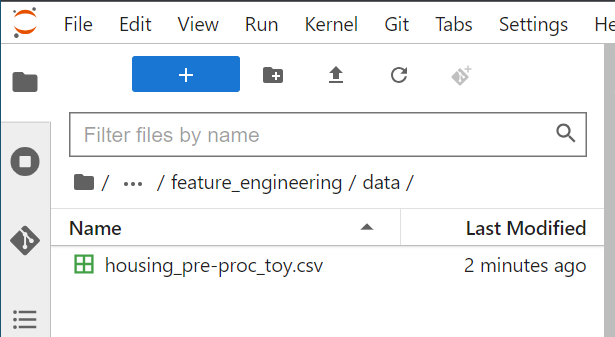

In [ ]:
# `ls` to polecenie powłoki Linuksa, które wyświetla zawartość katalogu
# Flaga `l` wyświetla listę wszystkich plików z uprawnieniami i szczegółami
!ls -l ../data/

total 140
-rw-r--r-- 1 jupyter jupyter 142150 Dec 27 07:25 housing_pre-proc_toy.csv


Teraz przeczytajmy zbiór danych właśnie skopiowany z zasobnika pamięci w chmurze i utwórz ramkę danych Pandy.

Parametr `error_bad_lines=False` w funkcji `pd.read_csv()` wskazuje, że podczas odczytywania pliku CSV należy pominąć linie, które zawierają błędy. Domyślna wartość tego parametru to `True`, co oznacza, że jeśli podczas odczytywania linii wystąpi błąd, funkcja `pd.read_csv()` zgłosi wyjątek.

Ustawienie parametru `error_bad_lines=False` może być przydatne, jeśli plik CSV zawiera linie, które zawierają błędy, ale nadal chcesz odczytać pozostałe dane w pliku. Na przykład, jeśli plik CSV zawiera dane o cenach nieruchomości, a niektóre linie zawierają błędne ceny, możesz ustawić parametr `error_bad_lines=False`, aby pominąć te linie i odczytać pozostałe dane o cenach nieruchomości.

In [ ]:
# `head()` function is used to get the first n rows of dataframe
housing_df = pd.read_csv('../data/housing_pre-proc_toy.csv', error_bad_lines=False)
housing_df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY


Możemy użyć metody `.describe()`, aby wyświetlić statystyki podsumowujące pola numeryczne w naszej ramce danych. Zwróć na przykład uwagę na wiersz licznika i odpowiadające mu kolumny. Liczba pokazuje 2500,000000 dla wszystkich kolumn funkcji. Zatem nie ma żadnych brakujących wartości.

In [ ]:
# `describe()` is use to get the statistical summary of the DataFrame
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,-121.501836,37.802288,30.088400,2522.734000,491.862400,1246.225200,458.122000,3.694312,170288.731200
std,1.015963,0.803090,13.878416,1988.411988,362.499497,925.075463,341.744308,1.859422,97550.278529
min,-124.300000,36.130000,2.000000,12.000000,4.000000,18.000000,2.000000,0.499900,22500.000000
25%,-122.200000,37.600000,18.000000,1420.750000,282.000000,718.000000,263.000000,2.357875,92950.000000
50%,-122.030000,37.800000,30.000000,2052.000000,402.000000,1030.500000,374.500000,3.262200,150800.000000
75%,-120.697500,37.960000,41.000000,3007.250000,581.250000,1488.250000,538.000000,4.662975,219650.000000
max,-118.910000,41.950000,52.000000,28258.000000,3864.000000,12203.000000,3701.000000,15.000100,500001.000000


#### Podziel zbiór danych dla ML

Załadowany przez nas zbiór danych był pojedynczym plikiem CSV. Podzielimy to na zbiory treningowe, walidacyjne i testowe.


In [ ]:
# Let's split the dataset into train, validation, and test sets
train, test = train_test_split(housing_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

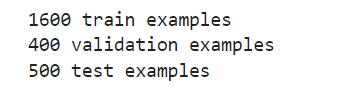

Teraz musimy wyprowadzić podzielone pliki. Plik test.csv będzie nam szczególnie potrzebny później do testów. Powinieneś zobaczyć, że pliki pojawiają się w katalogu domowym.

In [ ]:
train.to_csv('../data/housing-train.csv', encoding='utf-8', index=False)

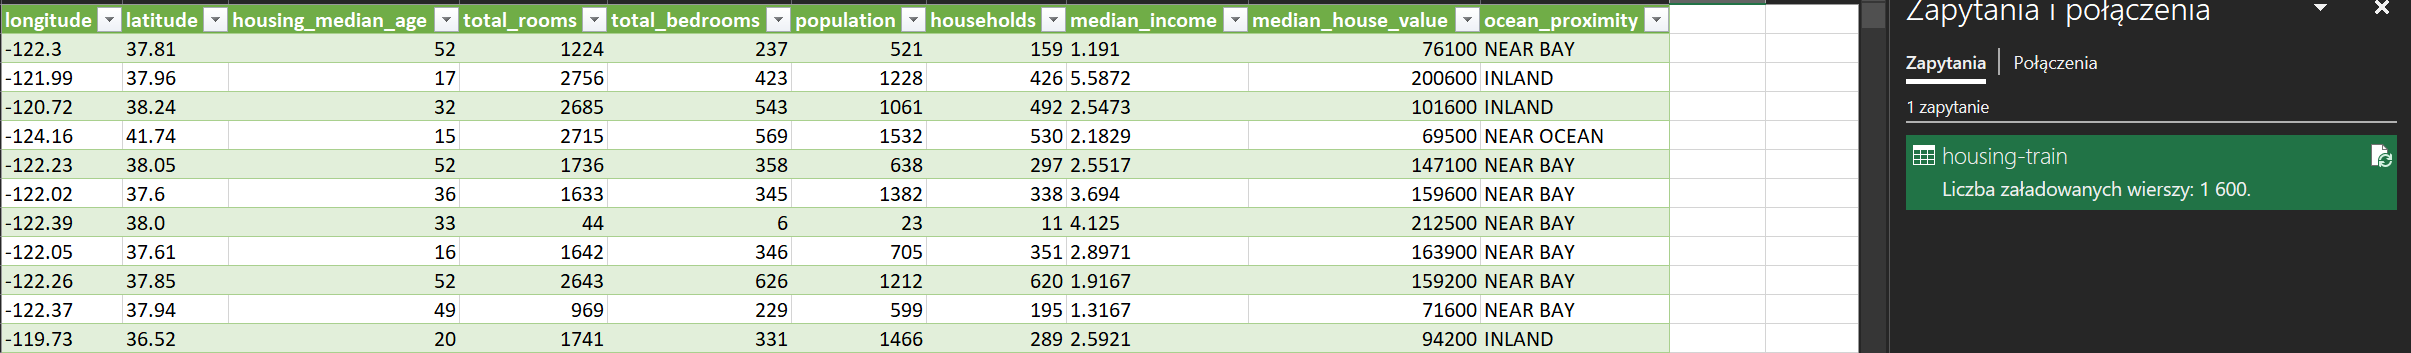

In [ ]:
train.to_csv('../data/housing-train2.csv', encoding='utf-8')

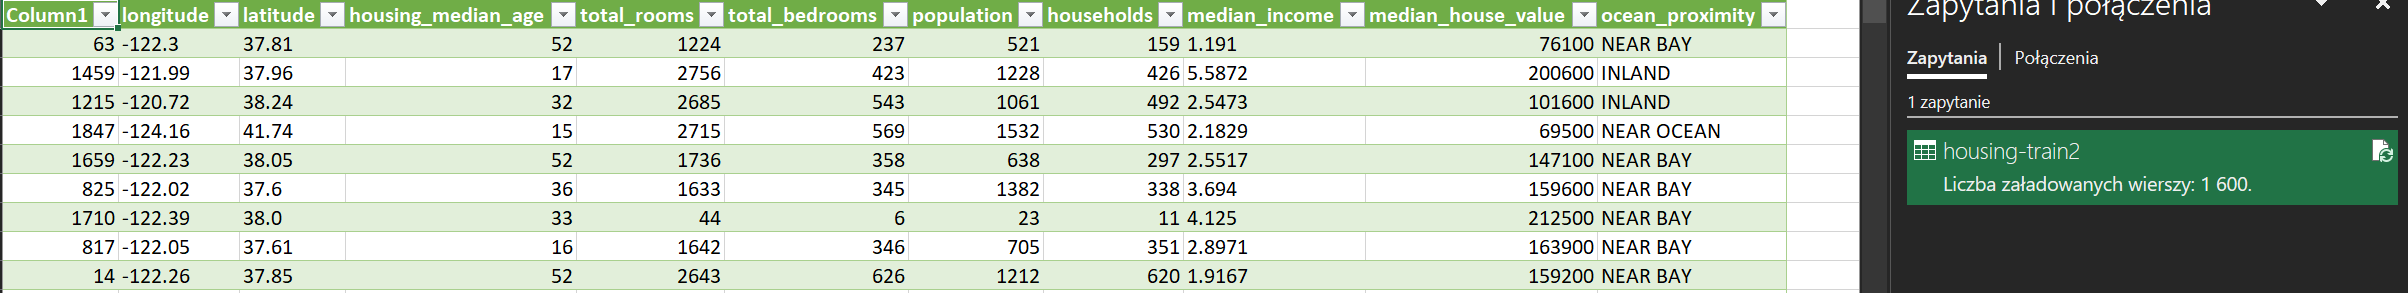

In [ ]:
val.to_csv('../data/housing-val.csv', encoding='utf-8', index=False)

In [ ]:
test.to_csv('../data/housing-test.csv', encoding='utf-8', index=False)

In [ ]:
!head ../data/housing*.csv

==> ../data/housing-test.csv <==
longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-119.46,36.61,13,1348,258,719,246,3.625,108300,INLAND
-119.65,36.51,30,1671,319,966,282,3.1333,100000,INLAND
-121.6,37.9,5,14684,2252,4276,1722,6.9051,340900,INLAND
-121.82,38.0,29,2070,452,985,420,2.8466,113400,INLAND
-121.76,37.67,6,3023,518,1225,468,6.3705,350000,INLAND
-121.64,37.85,22,1999,415,967,320,4.4583,253900,INLAND
-122.22,37.78,50,1920,530,1525,477,1.4886,128800,NEAR BAY
-121.6,39.79,18,2672,533,1151,532,2.567,102900,INLAND
-122.19,37.71,36,361,69,158,58,5.5461,262500,NEAR BAY

==> ../data/housing-train.csv <==
longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-119.99,38.93,23,1882,414,673,277,2.9091,141900,INLAND
-122.02,37.63,6,2445,590,1189,573,3.8958,301100,NEAR BAY
-122.28,37.8,38,684,176,344,155,2.0114,131300,NEAR BA

## Lab Task 1: Create an input pipeline using tf.data

Następnie opakujemy ramki danych plikiem [tf.data](https://www.tensorflow.org/guide/datasets). Umożliwi nam to użycie kolumn funkcji jako pomostu do mapowania kolumn w ramce danych Pandy na funkcje używane do uczenia modelu.

Tutaj tworzymy potok wejściowy za pomocą tf.data. W tej funkcji brakuje dwóch linii. Popraw i uruchom komórkę.

In [ ]:
# Metoda narzędziowa do tworzenia zestawu danych tf.data z ramki danych Pandas
# TODO 1a
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('median_house_value')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

Następnie inicjujemy zbiory danych szkoleniowych i walidacyjnych.

In [ ]:
batch_size = 32
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

2021-12-27 07:27:04.479100: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Teraz, gdy utworzyliśmy potok wejściowy, wywołajmy go, aby zobaczyć format zwracanych danych. Zastosowaliśmy niewielki rozmiar partii, aby zachować czytelność danych wyjściowych.

In [ ]:
# TODO 1b
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of households:', feature_batch['households'])
    print('A batch of ocean_proximity:', feature_batch['ocean_proximity'])
    print('A batch of targets:', label_batch)

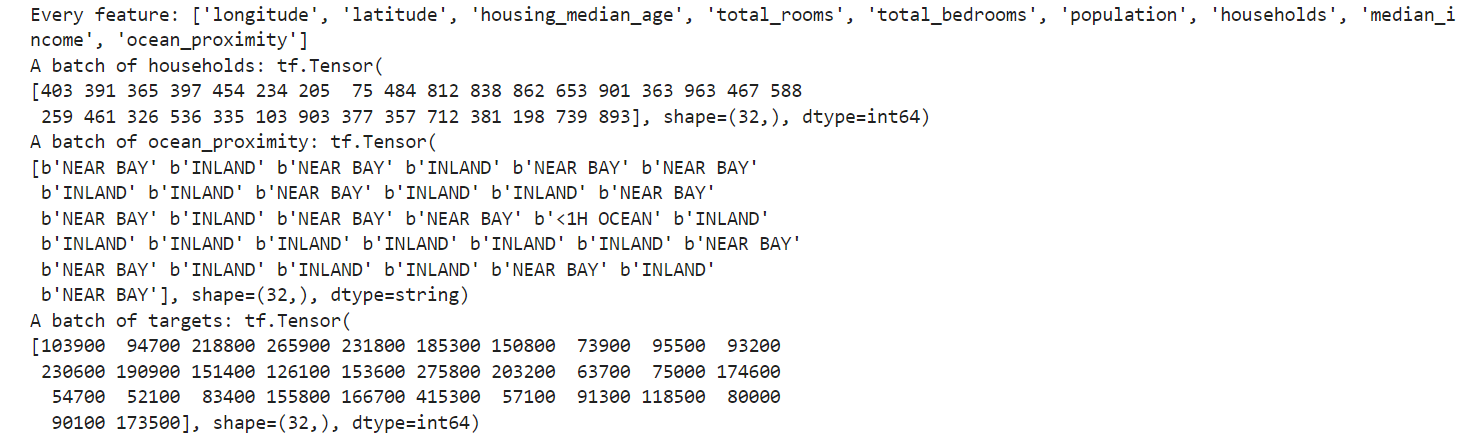

Widzimy, że zbiór danych zwraca słownik nazw kolumn (z ramki danych), które odwzorowują wartości kolumn z wierszy w ramce danych.

#### Kolumny numeryczne
Dane wyjściowe kolumny cech stają się danymi wejściowymi modelu. Liczbowe to najprostszy typ kolumny. Służy do reprezentowania naprawdę cenionych funkcji. Podczas korzystania z tej kolumny Twój model otrzyma wartość kolumny z ramki danych w niezmienionej postaci.

W zbiorze danych o cenach mieszkań w Kalifornii większość kolumn w ramce danych ma charakter liczbowy. Utwórzmy zmienną o nazwie **numeric_cols**, która będzie przechowywać tylko kolumny cech liczbowych.

In [ ]:
# Stwórzmy zmienną o nazwie `numeric_cols`, która będzie przechowywać tylko kolumny cech numerycznych.
# TODO 1c
numeric_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                'total_bedrooms', 'population', 'households', 'median_income']

#### Scaler function

Bardzo ważne jest, aby zmienne numeryczne zostały przeskalowane, zanim zostaną „wprowadzone” do sieci neuronowej. Tutaj używamy skalowania `min-max`. Tutaj tworzymy funkcję o nazwie `„get_scal”`, która pobiera listę cech numerycznych i zwraca funkcję `„minmax”`, która będzie używana w `tf.feature_column.numeric_column()` jako normalizer_fn w parametrach. Sama funkcja „Minmax” pobiera liczbę „numeryczną” z określonej funkcji i zwraca przeskalowaną wartość tej liczby.

Następnie skalujemy kolumny cech liczbowych, które przypisaliśmy do zmiennej „kolumny numeryczne”.

In [ ]:
# Funkcja „get_scal” pobiera listę funkcji numerycznych i zwraca funkcję „minmax”.
# Funkcja „Minmax” sama pobiera liczbę „numeryczną” z określonej funkcji i zwraca przeskalowaną wartość tej liczby.
# Skalar def get_scal(cecha):
# TODO 1d
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
        return(minmax)

In [ ]:
# TODO 1e
feature_columns = []
for header in numeric_cols:
    scal_input_fn = get_scal(header)
    feature_columns.append(fc.numeric_column(header,
                                             normalizer_fn=scal_input_fn))

Następnie powinniśmy sprawdzić całkowitą liczbę kolumn funkcji. Porównaj tę liczbę z liczbą wprowadzonych wcześniej funkcji numerycznych.

In [ ]:
print('Total number of feature coLumns: ', len(feature_columns))

Total number of feature coLumns:  8


### Korzystanie z modelu sekwencyjnego Keras

Następnie uruchomimy tę komórkę, aby skompilować i dopasować model Keras Sequential.

In [ ]:
# Tworzenie modelu
# `tf.keras.layers.DenseFeatures()` to warstwa, która tworzy gęsty tensor w oparciu o podane kolumny funkcji.
feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

# `tf.keras.Sequential()` grupuje liniowy stos warstw w tf.keras.Model.
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


2021-12-27 07:28:07.208447: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


36/50 [====================>.........] - ETA: 0s - loss: 38727671808.0000 - mse: 38727671808.0000WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'longitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'housing_median_age': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=int64>, 'total_rooms': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=int64>, 'total_bedrooms': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=int64>, 'population': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=int64>, 'households': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'median_income': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'ocean_proximity': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=string>}
Consider rewriting this model with the Functional API.
50/50 [==============================] - 1s 11ms/


Następnie pokazujemy stratę jako Mean Square Error (MSE). Pamiętaj, że MSE jest najczęściej używaną funkcją straty regresyjnej. MSE to suma kwadratów odległości między naszą zmienną docelową (np. średnim wiekiem mieszkania) a wartościami przewidywanymi.

In [ ]:
# Let's show loss as Mean Square Error (MSE)
loss, mse = model.evaluate(train_ds)
print("Mean Squared Error", mse)

50/50 [==============================] - 0s 3ms/step - loss: 15769783296.0000 - mse: 15769783296.0000
Mean Squared Error 15769783296.0


#### Wizualizuj krzywą strat modelu

Następnie użyjemy narzędzia Matplotlib do narysowania krzywych strat modelu na potrzeby szkolenia i walidacji. Tworzony jest także wykres liniowy pokazujący śmean squared error loss w epokach szkoleniowych zarówno dla zbioru treningowego (niebieski), jak i testowego (pomarańczowy).

In [ ]:
# Use matplotlib to draw the model's loss curves for training and validation
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');

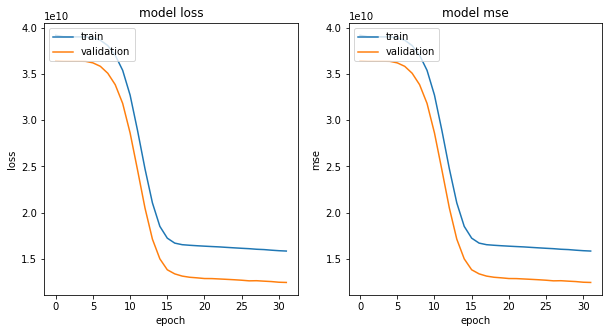

In [ ]:
plot_curves(history, ['loss', 'mse'])

### Load test data

Następnie wczytujemy plik test.csv i sprawdzamy, czy nie ma w nim wartości null.

Ponownie możemy użyć funkcji `.describe()`, aby wyświetlić statystyki podsumowujące dla pól numerycznych w naszej ramce danych. Liczba pokazuje 500,000000 dla wszystkich kolumn funkcji. Zatem nie ma żadnych brakujących wartości.

In [ ]:
test_data = pd.read_csv('../data/housing-test.csv')
test_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-121.484620,37.788780,29.434000,2454.474000,483.734000,1224.256000,451.594000,3.668661,170155.210000
std,1.021337,0.783415,14.118935,1762.173905,341.648965,825.955172,315.922007,1.884980,98074.219727
min,-124.230000,36.140000,2.000000,44.000000,6.000000,23.000000,11.000000,0.536000,39200.000000
25%,-122.182500,37.607500,17.000000,1431.750000,281.500000,736.750000,269.000000,2.269050,92550.000000
50%,-122.020000,37.800000,29.000000,1999.000000,405.000000,995.500000,371.000000,3.250000,151400.000000
75%,-120.620000,37.960000,40.000000,3024.250000,576.750000,1484.500000,522.500000,4.753050,218625.000000
max,-118.940000,41.750000,52.000000,14917.000000,2708.000000,8012.000000,2606.000000,12.591500,500001.000000


Teraz, gdy utworzyliśmy potok wejściowy za pomocą pliku `tf.data` i skompilowaliśmy model sekwencyjny Keras, tworzymy teraz funkcję wejściową dla danych testowych i inicjujemy zmienną test_predict.

In [ ]:
# TODO 1f
def test_input_fn(features, batch_size=256):
    """An input function for prediction."""
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

In [ ]:
test_predict = test_input_fn(dict(test_data))

#### Prognoza: regresja liniowa

Zanim zaczniemy projektować nasze kolumny funkcji, powinniśmy przewidzieć średnią wartość domu. Przewidując teraz średnią wartość domu, możemy następnie porównać ją ze średnią wartością domu po inżynierii cech.

Aby przewidzieć za pomocą Keras, po prostu wywołujesz [model.predict()](https://keras.io/models/model/#predict) i przekazujesz cechy obudowy, dla których chcesz przewidzieć medianę_wartości_domu. Uwaga: przewidujemy model lokalnie.

In [ ]:
# Use the model to do prediction with `model.predict()`
predicted_median_house_value = model.predict(test_predict)

Consider rewriting this model with the Functional API.


Następnie uruchamiamy dwie prognozy w oddzielnych komórkach – jedną, gdzieocean_proximity=INLAND and one where ocean_proximity= NEAR OCEAN.

In [ ]:
# Ocean_proximity is INLAND
model.predict({
    'longitude': tf.convert_to_tensor([-121.86]),
    'latitude': tf.convert_to_tensor([39.78]),
    'housing_median_age': tf.convert_to_tensor([12.0]),
    'total_rooms': tf.convert_to_tensor([7653.0]),
    'total_bedrooms': tf.convert_to_tensor([1578.0]),
    'population': tf.convert_to_tensor([3628.0]),
    'households': tf.convert_to_tensor([1494.0]),
    'median_income': tf.convert_to_tensor([3.0905]),
    'ocean_proximity': tf.convert_to_tensor(['INLAND'])
}, steps=1)

Consider rewriting this model with the Functional API.


array([[343034.]], dtype=float32)

In [ ]:
# Ocean_proximity is NEAR OCEAN
model.predict({
    'longitude': tf.convert_to_tensor([-122.43]),
    'latitude': tf.convert_to_tensor([37.63]),
    'housing_median_age': tf.convert_to_tensor([34.0]),
    'total_rooms': tf.convert_to_tensor([4135.0]),
    'total_bedrooms': tf.convert_to_tensor([687.0]),
    'population': tf.convert_to_tensor([2154.0]),
    'households': tf.convert_to_tensor([742.0]),
    'median_income': tf.convert_to_tensor([4.9732]),
    'ocean_proximity': tf.convert_to_tensor(['NEAR OCEAN'])
}, steps=1)

array([[190023.45]], dtype=float32)

Tablice zwracają przewidywaną wartość. Co oznaczają te liczby. Porównajmy tę wartość ze zbiorem testowym.

Przejdź do pliku test.csv, który przeczytałeś kilka komórek wyżej. Znajdź pierwszą linię i znajdź wartość median_house, która powinna wynosić 249 000 dolarów w pobliżu oceanu. Jaką wartość przewidział Twój model dla median_house_value? Czy był to solidny występ modelu? Zobaczmy, czy możemy to trochę ulepszyć dzięki inżynierii funkcji!

## Zadanie laboratoryjne 2: Projektowanie cech w celu utworzenia cech jakościowych i numerycznych

Teraz tworzymy komórkę wskazującą, które funkcje zostaną wykorzystane w modelu.
Uwaga: pamiętaj o podzieleniu na segmenty „housing_median_age” i upewnij się, że „ocean_proximity” jest zakodowane jednokrotnie. I nie zapomnij o wartościach liczbowych!

In [ ]:
# TODO 2a
numeric_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                'total_bedrooms', 'population', 'households', 'median_income']

bucketized_cols = ['housing_median_age']

# indicator columns,Categorical features
categorical_cols = ['ocean_proximity']

Następnie skalujemy kolumny liczbowe, przeliczeniowe i kategoryczne, które przypisaliśmy do zmiennych w poprzedniej komórce.

In [ ]:
# Scalar def get_scal(feature):
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
        return(minmax)

In [ ]:
# All numerical features - scaling
feature_columns = []
for header in numeric_cols:
    scal_input_fn = get_scal(header)
    feature_columns.append(fc.numeric_column(header,
                                             normalizer_fn=scal_input_fn))

### Cecha kategoryczna
W tym zbiorze danych „ocean_proximity” jest reprezentowane jako ciąg znaków. Nie możemy podawać ciągów znaków bezpośrednio do modelu. Zamiast tego musimy najpierw zmapować je na wartości liczbowe. Kolumny słownictwa kategorycznego umożliwiają reprezentowanie ciągów jako wektora jednopunktowego.

Następnie tworzymy obiekt kategoryczny za pomocą parametru „ocean_proximity”.

In [ ]:
# TODO 2b
for feature_name in categorical_cols:
    vocabulary = housing_df[feature_name].unique()
    categorical_c = fc.categorical_column_with_vocabulary_list(feature_name, vocabulary)
    one_hot = fc.indicator_column(categorical_c)
    feature_columns.append(one_hot)

### Bucketized Feature

Często nie chcesz wprowadzać liczby bezpośrednio do modelu, ale zamiast tego podzielić jej wartość na różne kategorie w oparciu o zakresy liczbowe. Rozważmy nasze surowe dane, które reprezentują wiek domów. Zamiast przedstawiać wiek domu jako kolumnę liczbową, możemy podzielić wiek domu na kilka segmentów za pomocą [bucketized column](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column). Zwróć uwagę, że poniższe wartości opisują, do jakiego przedziału wiekowego pasuje każdy wiersz.

Next we create a bucketized column using 'housing_median_age'


In [ ]:
# TODO 2c
age = fc.numeric_column("housing_median_age")

# Bucketized cols
age_buckets = fc.bucketized_column(age, boundaries=[10, 20, 30, 40, 50, 60, 80, 100])
feature_columns.append(age_buckets)

### Feature Cross

Łączenie cech w jedną, lepiej znaną jako [krzyżowanie cech](https://developers.google.com/machine-learning/glossary/#feature_cross), umożliwia modelowi poznanie oddzielnych wag dla każdej kombinacji cech.

Następnie tworzymy skrzyżowanie cech „housing_median_age” i „ocean_proximity”.

In [ ]:
# TODO 2d
vocabulary = housing_df['ocean_proximity'].unique()
ocean_proximity = fc.categorical_column_with_vocabulary_list('ocean_proximity',
                                                             vocabulary)

crossed_feature = fc.crossed_column([age_buckets, ocean_proximity],
                                    hash_bucket_size=1000)
crossed_feature = fc.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

Następnie powinniśmy sprawdzić całkowitą liczbę kolumn funkcji. Porównaj tę liczbę z liczbą wprowadzonych wcześniej funkcji numerycznych.

In [ ]:
print('Total number of feature columns: ', len(feature_columns))

Total number of feature columns:  11


Następnie uruchomimy tę komórkę, aby skompilować i dopasować model Keras Sequential. To ten sam model, który testowaliśmy wcześniej.

In [ ]:
# Model create
# `tf.keras.layers.DenseFeatures()` is a layer that produces a dense Tensor based on given feature_columns.
feature_layer = tf.keras.layers.DenseFeatures(feature_columns,
                                              dtype='float64')

# `tf.keras.Sequential()` groups a linear stack of layers into a tf.keras.Model.
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
48/50 [===========================>..] - ETA: 0s - loss: 39152873472.0000 - mse: 39152873472.0000WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'longitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'housing_median_age': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=int64>, 'total_rooms': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=int64>, 'total_bedrooms': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=int64>, 'population': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=int64>, 'households': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'median_income': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'ocean_proximity': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1

Next, we show loss and mean squared error then plot the model.

In [ ]:
loss, mse = model.evaluate(train_ds)
print("Mean Squared Error", mse)

50/50 [==============================] - 0s 4ms/step - loss: 15794762752.0000 - mse: 15794762752.0000
Mean Squared Error 15794762752.0


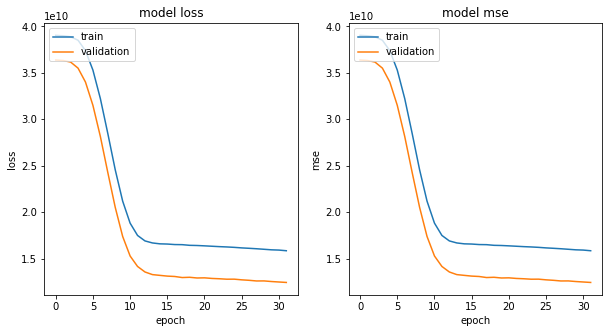

In [ ]:
plot_curves(history, ['loss', 'mse'])

Next we create a prediction model.  Note:  You may use the same values from the previous prediciton.  

In [ ]:
# TODO 2e
# Median_house_value is $249,000, prediction is $234,000 NEAR OCEAN
model.predict({
    'longitude': tf.convert_to_tensor([-122.43]),
    'latitude': tf.convert_to_tensor([37.63]),
    'housing_median_age': tf.convert_to_tensor([34.0]),
    'total_rooms': tf.convert_to_tensor([4135.0]),
    'total_bedrooms': tf.convert_to_tensor([687.0]),
    'population': tf.convert_to_tensor([2154.0]),
    'households': tf.convert_to_tensor([742.0]),
    'median_income': tf.convert_to_tensor([4.9732]),
    'ocean_proximity': tf.convert_to_tensor(['NEAR OCEAN'])
}, steps=1)

Consider rewriting this model with the Functional API.


array([[192184.52]], dtype=float32)

### Analiza

Tablica zwraca przewidywaną wartość. Porównaj tę wartość z zestawem testowym, który uruchomiłeś wcześniej. Przewidywana wartość może być nieco lepsza.

Teraz, gdy masz już skonfigurowany „szablon inżynierii funkcji”, możesz eksperymentować, tworząc dodatkowe funkcje. Można na przykład utworzyć funkcje pochodne, takie jak liczba gospodarstw domowych na populację, i sprawdzić, jaki mają one wpływ na model. Możesz także poeksperymentować z zastąpieniem elementów użytych do utworzenia krzyża obiektów.

Copyright 2022 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.